In [1]:
import sys
import pandas as pd

sys.path.append('..')

import torch
from torch.utils.data import DataLoader
from sklearn import datasets
from sklearn.model_selection import train_test_split

# DEID libraries
from gojo import core
from gojo import deepl
from gojo import util

In [2]:
# load test dataset (Wine)
wine_dt = datasets.load_wine()

# create the target variable. Classification problem 0 vs rest
# to see the target names you can use wine_dt['target_names']
y = (wine_dt['target'] == 1).astype(int)  
X = wine_dt['data']

# standarize input data
std_X = util.zscoresScaling(X)

# split Xs and Ys in training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    std_X, y, train_size=0.8, random_state=1997, shuffle=True,
    stratify=y
)
X_train.shape, X_valid.shape, '%.3f' % y_train.mean(),  '%.3f' % y_valid.mean()

((142, 13), (36, 13), '0.401', '0.389')

In [3]:
# create the dataloaders
train_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_train, y=y_train), 
    batch_size=16, shuffle=True)

valid_dl = DataLoader(
    deepl.loading.TorchDataset(X=X_valid, y=y_valid), 
    batch_size=X_valid.shape[0], shuffle=False)

In [4]:
# create a basic model
model = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 20),
    torch.nn.ELU(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=13, out_features=20, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=20, out_features=1, bias=True)
  (3): Sigmoid()
)

In [5]:
output = deepl.fitNeuralNetwork(
    deepl.iterSupervisedEpoch,
    model=model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    n_epochs=50,
    loss_fn=torch.nn.BCELoss(),
    optimizer_class=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    device='mps',
    metrics=core.getDefaultMetrics('binary_classification', bin_threshold=0.5)
)


Epoch (1) ============================================ 
	 (train) loss (mean): 0.69353
	 (train) loss (std): 0.03923
	 (train) accuracy: 0.50000
	 (train) balanced_accuracy: 0.56213
	 (train) precision: 0.43860
	 (train) recall: 0.87719
	 (train) sensitivity: 0.87719
	 (train) specificity: 0.24706
	 (train) negative_predictive_value: 0.75000
	 (train) f1_score: 0.58480
	 (train) auc: 0.56213

	 (valid) loss (mean): 0.65316
	 (valid) loss (std): 0.00000
	 (valid) accuracy: 0.58333
	 (valid) balanced_accuracy: 0.64610
	 (valid) precision: 0.48148
	 (valid) recall: 0.92857
	 (valid) sensitivity: 0.92857
	 (valid) specificity: 0.36364
	 (valid) negative_predictive_value: 0.88889
	 (valid) f1_score: 0.63415
	 (valid) auc: 0.64610


Epoch (2) ============================================ 
	 (train) loss (mean): 0.65382
	 (train) loss (std): 0.03733
	 (train) accuracy: 0.59155
	 (train) balanced_accuracy: 0.64438
	 (train) precision: 0.49524
	 (train) recall: 0.91228
	 (train) sensitivity: 0.

In [8]:
pd.DataFrame(output['train_metrics']).join

,accuracy,balanced_accuracy,precision,recall,sensitivity,specificity,negative_predictive_value,f1_score,auc
0,0.500000,0.562126,0.438596,0.877193,0.877193,0.247059,0.750000,0.584795,0.562126
1,0.591549,0.644376,0.495238,0.912281,0.912281,0.376471,0.864865,0.641975,0.644376
2,0.676056,0.714964,0.559140,0.912281,0.912281,0.517647,0.897959,0.693333,0.714964
3,0.753521,0.782559,0.630952,0.929825,0.929825,0.635294,0.931034,0.751773,0.782559
4,0.816901,0.838390,0.701299,0.947368,0.947368,0.729412,0.953846,0.805970,0.838390
5,0.859155,0.873684,0.760563,0.947368,0.947368,0.800000,0.957746,0.843750,0.873684
6,0.894366,0.903096,0.818182,0.947368,0.947368,0.858824,0.960526,0.878049,0.903096
7,0.901408,0.908978,0.830769,0.947368,0.947368,0.870588,0.961039,0.885246,0.908978
8,0.901408,0.908978,0.830769,0.947368,0.947368,0.870588,0.961039,0.885246,0.908978
9,0.915493,0.923633,0.846154,0.964912,0.964912,0.882353,0.974026,0.901639,0.923633


<Axes: >

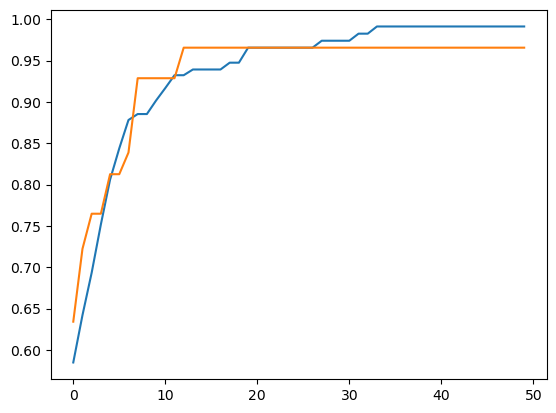

In [7]:
pd.DataFrame(output['train_metrics'])['f1_score'].plot()
pd.DataFrame(output['valid_metrics'])['f1_score'].plot()